# Identifying Salt in Seismic Sections Using a Deep Learning Model

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


### Visualise the seismic section and salt

In [4]:
data = mpimg.imread('../data/seismic.tif')
data.shape

(1036, 2350, 3)

In [5]:
mask = mpimg.imread('../data/mask.tif')
mask.shape

(1036, 2350)

In [6]:
# Scale data
data = data[:, :, :1]/255  # Use only the first channel
mask = (mask - mask.min()) / (mask.max() - mask.min())

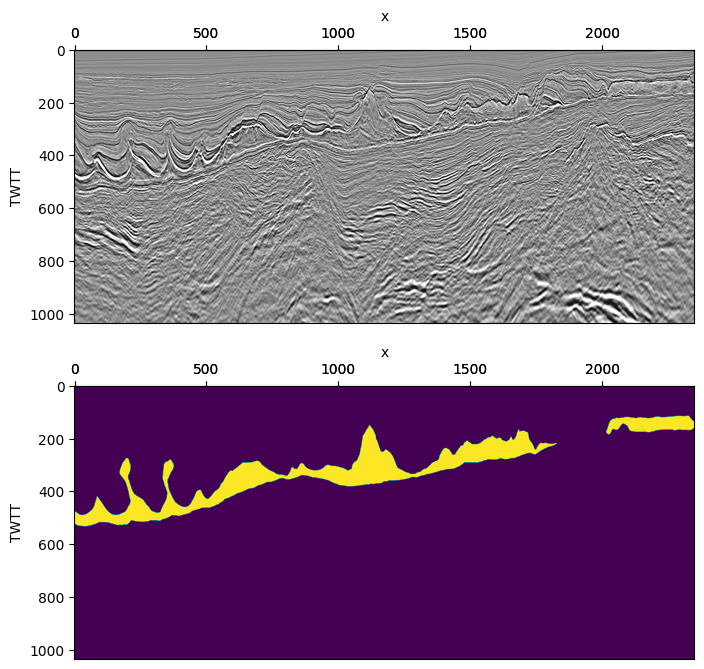

In [7]:
# Visualise the data
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].matshow(data[:, :, 0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
axs[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[0].set_ylabel("TWTT")
secax = axs[0].secondary_xaxis('top')
secax.set_xlabel('x')
axs[1].matshow(mask, interpolation='spline16', aspect=1)
axs[1].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[1].set_ylabel("TWTT")
secax = axs[1].secondary_xaxis('top')
secax.set_xlabel('x');

### Create a dataset

เราต้องมี seismic section มากกว่านี้ในการเทรน deep learning model แต่เราไม่มีเวลา เราจะแบ่ง seismic section (input) และ mask (label) ออกเป็นหลาย ๆ ภาพแทน

In [8]:
def patchify(data, mask, num_patches, img_dim):
    X = np.empty((num_patches, *img_dim))
    y = np.empty((num_patches, 1))
    t_max, x_max, _ = data.shape

    for n in range(num_patches):
        # Select a random point in the seismic section (not at the edge)   
        x_n = random.randint(
            img_dim[1]//2,
            x_max - img_dim[1]//2
        )
        t_n = random.randint(
            img_dim[0]//2,
            t_max - img_dim[0]//2
        )

        # Crop image around the random point 
        X[n, :, :, 0] = data[
            t_n - img_dim[0]//2: t_n + img_dim[0]//2,
            x_n - img_dim[1]//2: x_n + img_dim[1]//2,
            0
        ]

        # Label (0 = non-salt, 1 = salt)
        if mask[t_n, x_n] >= 0.1:
            y[n] = 1
        else:
            y[n] = 0

    return X, y

In [9]:
num_train_samples = 5000  # The number of training samples
num_test_samples = 1000  # The mumber of validation samples
img_dim = (64, 64, 1)  # The size of a sample

In [10]:
# Train-test split
X_train, y_train = patchify(data[:, :1200], mask[:, :1200], num_train_samples, img_dim)
X_test, y_test = patchify(data[:, 1200:], mask[:, 1200:], num_test_samples, img_dim)

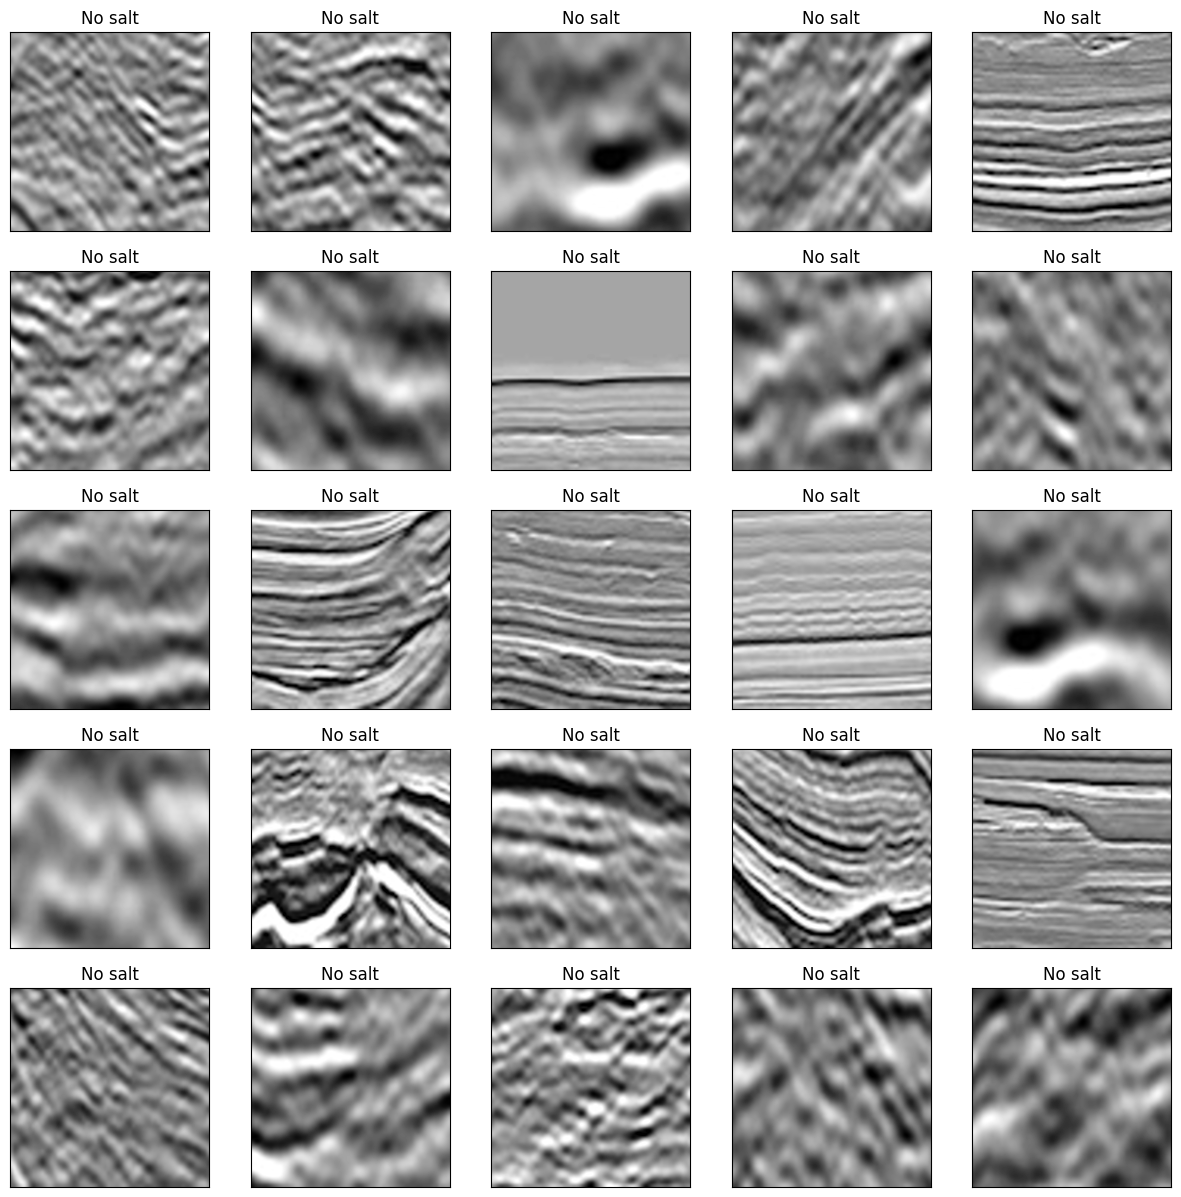

In [11]:
# Visualise some samples
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for m in range(5):
    for n in range(5):
        idx = 5*m + n
        axs[m, n].imshow(X_train[idx, :, :, 0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
        axs[m, n].set(xticks=[], yticks=[])
        if y_train[idx, 0] == 1:
            axs[m, n].set_title('salt')
        else:
            axs[m, n].set_title('No salt')

In [12]:
# Create TensorDataset
train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

In [13]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(start_dim=1),
            nn.Linear(4096, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, 2, bias=True),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

In [14]:
X = torch.randn(1, 1, 64, 64).to(device)
model = CNN().to(device)
y = model(X)
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                  [-1, 512]       2,097,664
             ReLU-12                  [-1, 512]               0
           Linear-13                    [-1, 2]           1,026
          Softmax-14                   

In [15]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0., 0.
    
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X.view(-1, 1, 64, 64))
        loss = criterion(y_pred, y.flatten().long())
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = y_pred.max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    avg_train_loss = train_loss/len(data_loader.dataset)
    avg_train_accuracy = train_accuracy/len(data_loader.dataset)
    return avg_train_loss, avg_train_accuracy

def validate(model, criterion, data_loader):
    model.eval()
    val_loss, val_accuracy = 0., 0.

    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            y_pred = model(X.view(-1, 1, 64, 64))
            loss = criterion(y_pred, y.flatten().long())
            val_loss += loss*X.size(0)
            y_pred = y_pred.max(1)[1]
            val_accuracy += accuracy_score(
                y.cpu().numpy(),
                y_pred.cpu().numpy()
            )*X.size(0)
    
    avg_val_loss = val_loss/len(data_loader.dataset)
    avg_val_accuracy = val_accuracy/len(data_loader.dataset)
    return avg_val_loss, avg_val_accuracy

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []

    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            y_pred = model(X.view(-1, 1, 64, 64))
            y_pred = y_pred.max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [16]:
# Set hyperparameters
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 100
n_epochs = 10

In [17]:
# Initialise the CNN, an SGD optimiser and a loss function
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [18]:
# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [19]:
# Train and validate the network and plot its learning curves
# You can use the "livelossplot" module to plot a real-time evolution of loss and accuracy 
set_seed(seed)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_loss, val_accuracy = validate(model, criterion, test_loader)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

KeyboardInterrupt: 

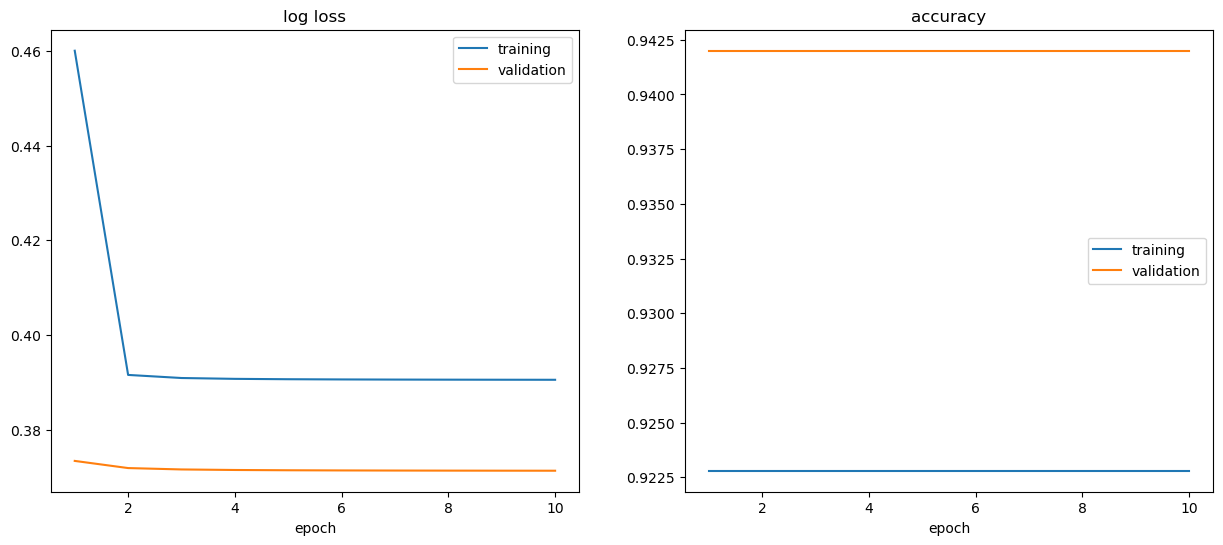

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(range(1, n_epochs+1), train_losses, label="training")
axs[0].plot(range(1, n_epochs+1), val_losses, label="validation")
axs[0].set(title="log loss", xlabel="epoch")
axs[0].legend()
axs[1].plot(range(1, n_epochs+1), train_accuracies, label="training")
axs[1].plot(range(1, n_epochs+1), val_accuracies, label="validation")
axs[1].set(title="accuracy", xlabel="epoch")
axs[1].legend();

In [21]:
# Use the validation set to predict labels
ys, y_preds, = evaluate(model, test_loader)

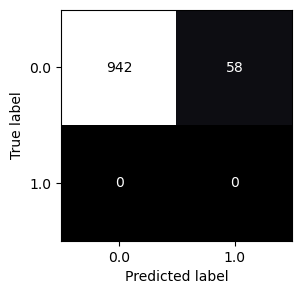

In [22]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(ys, y_preds, ax=ax, colorbar=False, cmap='bone');

```{note}
- Accuracy ไม่ใช่ metric ที่ดี เพราะข้อมูล imbalanced (ใช้ F1 น่าจะดีกว่า)
- เราสามารถพัฒนา model ได้ เช่น ทำ data augmentation, ปรับเปลี่ยน CNN architecture (เพิ่มหรือลดจำนวน layer, เปลี่ยน activation function), ทำ hyperparameter tuning
```